### Convolutional Neural Nets on CIFAR10 Data

In [1]:
import torch 
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

# Make matplotlib plot pretty pictures
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 14.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Reload external modules
%load_ext autoreload
%autoreload 2

In [2]:
# Hyper Parameters
num_epochs = 5
batch_size = 100
learning_rate = 0.001

#### Define your CNN

Again, we need two functions in the class - 

1. `__init__` : Define the structure of your CNN, and specify the layers. 
    * For our specific model of input 32x32x3 (Remember that we simply sum over the z-axis in our kernels, so they always have the same size along the z-axis as the input)
        * 2D Conv Layer: 16 (5x5x3) kernels, padding of 2 -> 32x32x16
        * BatchNorm Layer: Normalize the outputs -> 32x32x16
        * RELU Layer: Apply activation function -> 32x32x16
        * MaxPool Layer: Downsample the output by taking max of each 2x2 square (in xy plane)-> 16x16x16
        * 2D Conv Layer: 32 (5x5x16) kernels, padding of 2 -> 16x16x32
        * BatchNorm Layer: Normalize the outputs -> 16x16x32
        * RELU Layer: Apply activation function -> 16x16x32
        * MaxPool Layer: Downsample the output by taking max of each 2x2 square (in xy plane)-> 8x8x32
        * A fully-connected normal NN, of size `8*8*32 x 10` that takes each voxel of the output to classify into 10 classes
        
2. `forward` : Specify how the input propagates through the layers

In [ ]:
# CNN Model (2 conv layer)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(8*8*32, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # The view function is used to reshape tensors
        out = self.fc(out)
        return out

In [ ]:
# CIFAR10 Dataset
train_dataset = dsets.CIFAR10(root='./data/',
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=False)  # Change to True for the first time you're downloading data

test_dataset = dsets.CIFAR10(root='./data/',
                           train=False, 
                           transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)
        
cnn = CNN()
cnn.cuda()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

# Train the Model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))

# Test the Model

# Here's where it diverges from tutorial 2, due to Batch Normalization
cnn.eval()    # Change model to 'eval' mode (BN uses moving mean/var).
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images).cuda()
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.cpu() == labels).sum()

print('Test Accuracy of the model on the 10000 test images: %d %%' % (100 * correct / total))

# Save the Trained Model
torch.save(cnn.state_dict(), 'cnn.pkl')

In [ ]:
from scipy import signal

layer1 = cnn.layer1[0].weight.data.cpu().numpy()

#layer1 = np.moveaxis(layer1, 1, -1)
print(layer1.shape)

plt.imshow((255*layer1[2][0]).astype('uint8'))

for i in range(16):
		plt_idx = i
		plt.subplot(4, 4, plt_idx+1)
		plt.imshow((255*layer1[i][0]))
		plt.axis('off')
		if i == 0:
			plt.title('first layer weights')
            
plt.show()

In [ ]:
image, label = train_dataset[5]

image = image.numpy()

image = np.moveaxis(image, 0, -1)
print(image.shape)
plt.imshow(image)
fig = plt.gcf()
fig.set_size_inches(3, 3)
plt.show()

image = np.moveaxis(image, -1, 0)

print(image.shape)
for i in range(16):
		plt_idx = i
		plt.subplot(4, 4, plt_idx+1)
		plt.imshow(signal.convolve2d(image[0], layer1[i][1]))
		plt.axis('off')
		if i == 0:
			plt.title('first layer weights')

In [3]:
# CNN Model (2 conv layer)
class CNN_MNIST(nn.Module):
    def __init__(self):
        super(CNN_MNIST, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # The view function is used to reshape tensors
        out = self.fc(out)
        return out

In [4]:
# MNIST Dataset
train_dataset = dsets.MNIST(root='./data/',
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)  # Change to True for the first time you're downloading data

test_dataset = dsets.MNIST(root='./data/',
                           train=False, 
                           transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)
        
cnn = CNN_MNIST()
cnn.cuda()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

# Train the Model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))

# Test the Model

# Here's where it diverges from tutorial 2, due to Batch Normalization
cnn.eval()    # Change model to 'eval' mode (BN uses moving mean/var).
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images).cuda()
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.cpu() == labels).sum()

print('Test Accuracy of the model on the 10000 test images: %d %%' % (100 * correct / total))

# Save the Trained Model
torch.save(cnn.state_dict(), 'cnn.pkl')

Epoch [1/5], Iter [100/600] Loss: 0.1321
Epoch [1/5], Iter [200/600] Loss: 0.0644
Epoch [1/5], Iter [300/600] Loss: 0.0577
Epoch [1/5], Iter [400/600] Loss: 0.0846
Epoch [1/5], Iter [500/600] Loss: 0.1122
Epoch [1/5], Iter [600/600] Loss: 0.0694
Epoch [2/5], Iter [100/600] Loss: 0.0213
Epoch [2/5], Iter [200/600] Loss: 0.0066
Epoch [2/5], Iter [300/600] Loss: 0.0904
Epoch [2/5], Iter [400/600] Loss: 0.0597
Epoch [2/5], Iter [500/600] Loss: 0.0340
Epoch [2/5], Iter [600/600] Loss: 0.0199
Epoch [3/5], Iter [100/600] Loss: 0.0066
Epoch [3/5], Iter [200/600] Loss: 0.0166
Epoch [3/5], Iter [300/600] Loss: 0.0071
Epoch [3/5], Iter [400/600] Loss: 0.0701
Epoch [3/5], Iter [500/600] Loss: 0.0286
Epoch [3/5], Iter [600/600] Loss: 0.0978
Epoch [4/5], Iter [100/600] Loss: 0.0416
Epoch [4/5], Iter [200/600] Loss: 0.0104
Epoch [4/5], Iter [300/600] Loss: 0.0916
Epoch [4/5], Iter [400/600] Loss: 0.0208
Epoch [4/5], Iter [500/600] Loss: 0.0297
Epoch [4/5], Iter [600/600] Loss: 0.0561
Epoch [5/5], Ite

(16, 1, 5, 5)


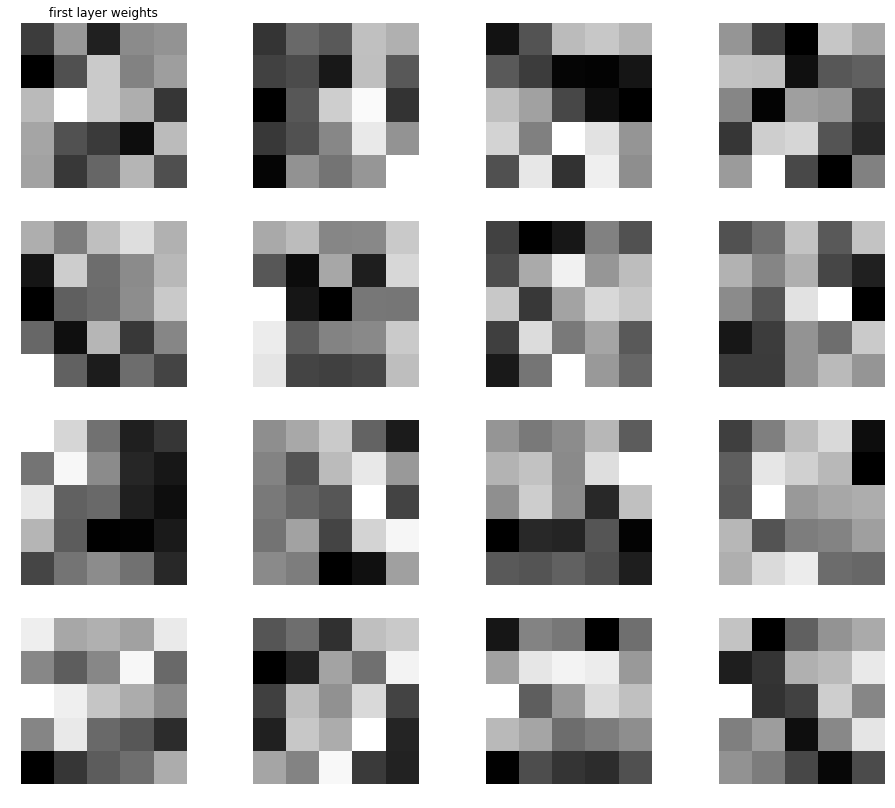

(1, 28, 28)


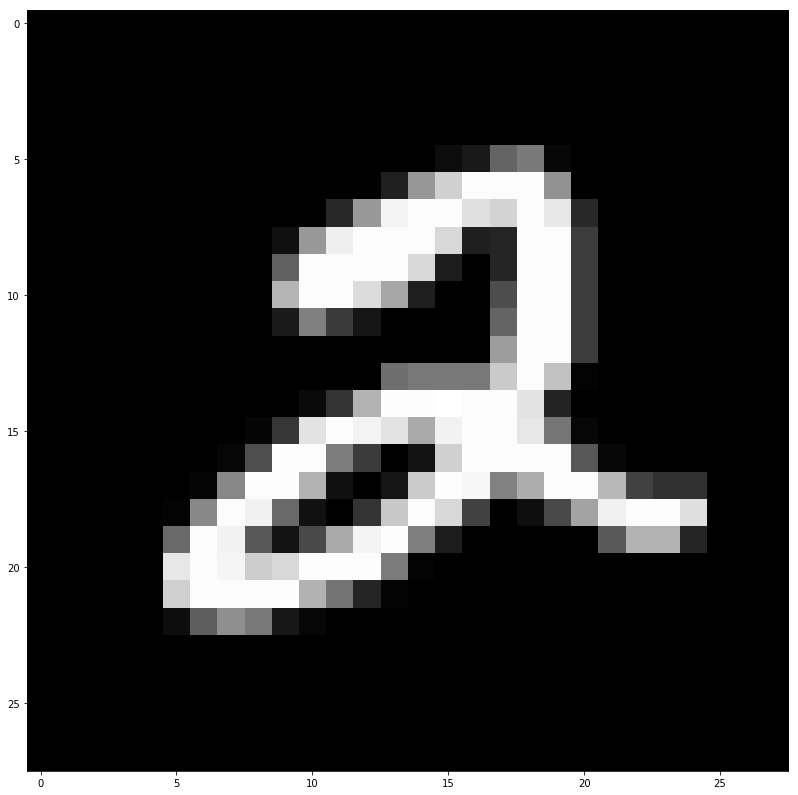

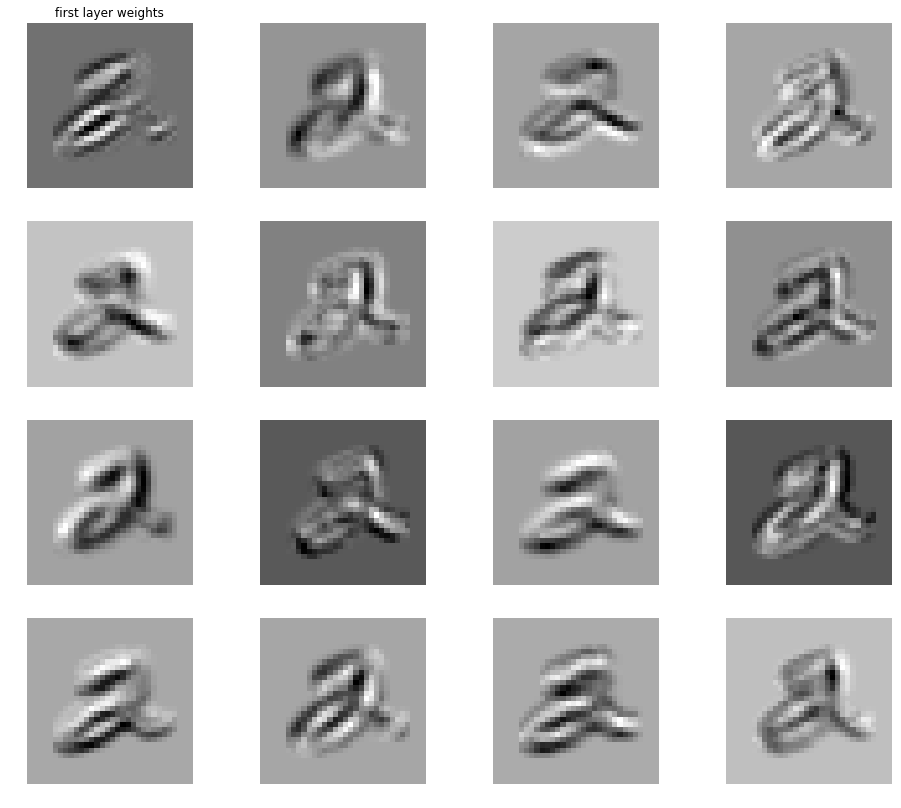

In [5]:
from scipy import signal

layer1 = cnn.layer1[0].weight.data.cpu().numpy()

#layer1 = np.moveaxis(layer1, 1, -1)
print(layer1.shape)

plt.imshow((255*layer1[2][0]).astype('uint8'))

for i in range(16):
		plt_idx = i
		plt.subplot(4, 4, plt_idx+1)
		plt.imshow((255*layer1[i][0]))
		plt.axis('off')
		if i == 0:
			plt.title('first layer weights')
            
plt.show()
image, label = train_dataset[5]

image = image.numpy()

#image = np.moveaxis(image, 0, -1)
print(image.shape)
plt.imshow(image[0])
plt.show()

for i in range(16):
		plt_idx = i
		plt.subplot(4, 4, plt_idx+1)
		plt.imshow(signal.convolve2d(image[0], layer1[i][0]))
		plt.axis('off')
		if i == 0:
			plt.title('first layer weights')